<a href="https://colab.research.google.com/github/ttarom/Anime_recommendation/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Anime Recommender System - Tamir Tarom**<br>
Nowadays, we can see many VOD systems like Netflix, Amazon Prime, hulu and more.<br> These systems run algorithms to understand each individual user and its preferences.<br> However, one of the main setbacks is having a cold start. meaning that the user is just a vanilla and he never saw any show that is in the system, so how can one expect the system to know anything about the user?<br>
<br>
In this notebook, we will explore some datasets about users and shows and will try to create a model that forecast recommendations to Animes using other criterions for a cold start.



In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from scipy import stats
from scipy.stats import skew
from scipy.stats import mode
from scipy.optimize import minimize
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
plt.rcParams['axes.facecolor'] = 'White'
init_notebook_mode(connected=True) 

import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Let's mount google drive so we can read data files:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/datasets_anime/users_cleaned.csv"
df_user = pd.read_csv(path)

path = "/content/drive/My Drive/Colab Notebooks/datasets_anime/anime_cleaned.csv"
df_anime = pd.read_csv(path)

df_anime = df_anime[df_anime['genre'].notna()].reset_index(drop=True)

In [ ]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108711 entries, 0 to 108710
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   username                  108710 non-null  object 
 1   user_id                   108711 non-null  int64  
 2   user_watching             108711 non-null  int64  
 3   user_completed            108711 non-null  int64  
 4   user_onhold               108711 non-null  int64  
 5   user_dropped              108711 non-null  int64  
 6   user_plantowatch          108711 non-null  int64  
 7   user_days_spent_watching  108711 non-null  float64
 8   gender                    108711 non-null  object 
 9   location                  108706 non-null  object 
 10  birth_date                108711 non-null  object 
 11  access_rank               0 non-null       float64
 12  join_date                 108711 non-null  object 
 13  last_online               108711 non-null  o

In [ ]:
df_user.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",1990-04-29 00:00:00,NaN,2013-03-03 00:00:00,2014-02-04 01:32:00,7.43,0.0,3391
1,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",1991-08-01 00:00:00,NaN,2008-02-13 00:00:00,2017-07-10 06:52:54,6.15,6.0,4903
2,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",1990-12-14 00:00:00,NaN,2009-08-31 00:00:00,2014-05-12 16:35:00,8.27,1.0,9701
3,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24 00:00:00,NaN,2010-05-10 00:00:00,2012-10-18 19:06:00,9.70,6.0,697
4,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",1999-10-24 00:00:00,NaN,2015-11-26 00:00:00,2018-05-10 20:53:37,7.86,0.0,1847


In [ ]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6664 entries, 0 to 6663
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6664 non-null   int64  
 1   title            6664 non-null   object 
 2   title_english    3436 non-null   object 
 3   title_japanese   6659 non-null   object 
 4   title_synonyms   4478 non-null   object 
 5   image_url        6662 non-null   object 
 6   type             6664 non-null   object 
 7   source           6664 non-null   object 
 8   episodes         6664 non-null   int64  
 9   status           6664 non-null   object 
 10  airing           6664 non-null   bool   
 11  aired_string     6664 non-null   object 
 12  aired            6664 non-null   object 
 13  duration         6664 non-null   object 
 14  rating           6664 non-null   object 
 15  score            6664 non-null   float64
 16  scored_by        6664 non-null   int64  
 17  rank          

In [ ]:
df_anime.head()

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,False,"Jan 13, 2012 to Mar 30, 2012","{'from': '2012-01-13', 'to': '2012-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,7.63,139250,1274.0,231,283882,2809,Inu x Boku SS was licensed by Sentai Filmworks...,Winter 2012,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,False,"Apr 2, 2007 to Oct 1, 2007","{'from': '2007-04-02', 'to': '2007-10-01'}",24 min. per ep.,PG-13 - Teens 13 or older,7.89,91206,727.0,366,204003,2579,NaN,Spring 2007,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,False,"Oct 4, 2008 to Sep 25, 2009","{'from': '2008-10-04', 'to': '2009-09-25'}",24 min. per ep.,PG - Children,7.55,37129,1508.0,1173,70127,802,NaN,Fall 2008,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,False,"Aug 16, 2002 to May 23, 2003","{'from': '2002-08-16', 'to': '2003-05-23'}",16 min. per ep.,PG-13 - Teens 13 or older,8.21,36501,307.0,916,93312,3344,Princess Tutu aired in two parts. The first pa...,Summer 2002,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,False,"Oct 6, 2012 to Mar 30, 2013","{'from': '2012-10-06', 'to': '2013-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,8.67,107767,50.0,426,182765,2082,NaN,Fall 2012,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0


Weighted Score = (v / (v + m)) * S + (m / (v + m)) * C<br>
S = Average score for the anime/manga<br>
v = Number users giving a score for the anime/manga †<br>
m = Minimum number of scored users required to get a calculated score<br>
C = The mean score across the entire Anime/Manga database<br>

Now we can see there are 3 different datasets, I want to join them effectivly, although it is not impossible to use join or merge with pandas, I decided to bring the final product ahead. I needed to structered query language, so I used SQL MS with these commands:
<br> 


```
CREATE TABLE [Anime].[dbo].[animelists_cleaned]
(
  [username] NVARCHAR(MAX) NULL, 
  [anime_id] NVARCHAR(MAX) NULL, 
  [my_watched_episodes] NVARCHAR(MAX) NULL,   
  [my_start_date] NVARCHAR(MAX) NULL, 
  [my_finish_date] NVARCHAR(MAX) NULL, 
  [my_score] NVARCHAR(MAX) NULL, 
  [my_status] NVARCHAR(MAX) NULL,   
  [my_rewatching] NVARCHAR(MAX) NULL, 
  [my_rewatching_ep] NVARCHAR(MAX) NULL, 
  [my_last_updated] NVARCHAR(MAX) NULL, 
  [my_tags] NVARCHAR(MAX) NULL
);


BULK INSERT [Anime].[dbo].[animelists_cleaned]
FROM 'D:\DS_final\dataset\animelists_cleaned.csv'
WITH
(
	FIRSTROW = 2,
    FIELDTERMINATOR = ',', 
    ROWTERMINATOR = '0x0a',
    ROWS_PER_BATCH = 10000, 
	TABLOCK
)

SELECT A.[username],[user_id],A.[anime_id]
,[my_watched_episodes],[my_start_date],[my_finish_date],[my_score]
,[my_status],[my_rewatching],[my_rewatching_ep],[my_last_updated],[my_tags]
,[title],[title_english],[title_japanese],[title_synonyms],[image_url],[type]
,[source],[episodes],[status],[airing],[aired_string],[aired],[duration]
,[rating],[score],[scored_by],[rank],[popularity],[members]
,[favorites],[background],[premiered],[broadcast],[related],[producer]
,[licensor],[studio],[genre],[opening_theme],[ending_theme],[duration_min]
,[aired_from_year],[user_watching],[user_completed],[user_onhold],[user_dropped]
,[user_plantowatch],[user_days_spent_watching],[gender],[location],[birth_date]
,[access_rank],[join_date],[last_online],[stats_mean_score],[stats_rewatched]
,[stats_episodes]

  FROM [Anime].[dbo].[animelists_cleaned] A
  JOIN [Anime].[dbo].[anime_cleaned] B
  ON A.anime_id = B.anime_id
  JOIN [Anime].[dbo].[users_cleaned] C
  ON A.username = C.username
```



In [ ]:
#And now to add this dataset
path = "/content/drive/My Drive/Colab Notebooks/datasets_anime/anime_combined.csv"
df_anime_c = pd.read_csv(path).sample(frac =0.1)

df_anime_c['birth_date'] = pd.to_datetime(df_anime_c['birth_date'], errors = 'coerce')
df_anime_c=df_anime_c[df_anime_c.birth_date.notnull()]

birth_date = df_anime_c.birth_date

 
age = []
for each in birth_date:
    age.append(round((datetime.now()-each).days/365.25,1))
df_anime_c['age'] = age
df_anime_c['age'] = df_anime_c[['age']].astype('int')
df_anime_c = df_anime_c[df_anime_c['genre'].notna()].reset_index(drop=True)


In [ ]:
df_anime_c['genre']

0              Action, Comedy, Super Power, Ecchi, School
1                           Comedy, Seinen, Slice of Life
2                           Drama, Romance, Slice of Life
3                  Action, Military, Sci-Fi, Magic, Ecchi
4                                                  Hentai
                                ...                      
3120022           Action, Adventure, Super Power, Shounen
3120023                   Action, Comedy, Fantasy, School
3120024                    Slice of Life, Mystery, School
3120025    Action, Demons, Supernatural, Fantasy, Shounen
3120026         Action, Adventure, Fantasy, Game, Romance
Name: genre, Length: 3120027, dtype: object

In [ ]:
df_anime_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3120027 entries, 0 to 3120026
Data columns (total 17 columns):
 #   Column               Dtype         
---  ------               -----         
 0   username             object        
 1   user_id              int64         
 2   anime_id             int64         
 3   popularity           int64         
 4   genre                object        
 5   my_watched_episodes  int64         
 6   my_start_date        object        
 7   my_finish_date       object        
 8   my_score             int64         
 9   my_status            int64         
 10  my_rewatching        float64       
 11  my_rewatching_ep     int64         
 12  my_last_updated      object        
 13  gender               object        
 14  location             object        
 15  birth_date           datetime64[ns]
 16  age                  int64         
dtypes: datetime64[ns](1), float64(1), int64(8), object(7)
memory usage: 404.7+ MB


In [ ]:
#taking the first genre out of each genres tag
df = df_anime_c.genre.fillna("")

genre_firsts = []
genre_list = []
genre_splited = []

for i in df.index:
    for j in df[i].split(", "):
        genre_splited.append(j)
        if j not in genre_list:
            genre_list.append(j)


for i in df.index:
    genre_firsts.append(df[i].split(", ")[0])

In [ ]:
genre_firsts[1:10]

['Comedy',
 'Drama',
 'Action',
 'Hentai',
 'Comedy',
 'Comedy',
 'Ecchi',
 'Action',
 'Comedy']

In [ ]:
df_anime_c['genre_1'] = genre_firsts

In [ ]:
df_anime_c.head()

,username,user_id,anime_id,popularity,genre,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,gender,location,birth_date,age,genre_1
0,happily_UnDead,2307201,18679,28,"Action, Comedy, Super Power, Ecchi, School",24,0000-00-00,0000-00-00,9,2,NaN,0,2014-10-14 16:14:53,Male,sweden,1994-07-02,26,Action
1,Lexg,5273470,32828,541,"Comedy, Seinen, Slice of Life",0,0000-00-00,0000-00-00,0,6,0.0,0,2016-07-04 22:21:28,Male,"Barcelona,Spain",1995-11-26,24,Comedy
2,amirkyunn,7056071,1689,96,"Drama, Romance, Slice of Life",3,0000-00-00,0000-00-00,10,2,0.0,0,2018-03-24 15:05:37,Male,"Ipoh,Perak",2002-06-19,18,Drama
3,Aku,467725,6381,1347,"Action, Military, Sci-Fi, Magic, Ecchi",12,2013-04-24,2013-04-30,4,2,0.0,0,2013-04-30 21:13:37,Male,"Milan, Italy",1989-10-23,30,Action
4,Detruo,1159255,2798,2858,Hentai,2,0000-00-00,0000-00-00,9,2,0.0,0,2012-02-22 17:44:51,Male,"Russia, Moscow",1993-12-12,26,Hentai


In [ ]:
#Looking at locations
df_anime_c['location'] = [x.split(",")[1].strip() if len(x.split(",")) > 1 else x.split(",")[0].strip() 
            for x in df_anime_c["location"].astype("str")]

df_anime_c['location'].head()

0    sweden
1     Spain
2     Perak
3     Italy
4    Moscow
Name: location, dtype: object

We can see that the location could be a state or a city.<br>
In some cases, they could be imaginary or irrelevant like "My Home".<br>
We will handle those in the best way possible.

In [ ]:
df_anime_c['location'] = ["USA" if x in ("USA", "United States of America", "U.S.A.", "US", "U.S.", "U.S.A", 
                           "usa", "United States", "California", "Texas", "New York", "Florida", 
                           "Ohio", "Michigan", "Illinois", "Washington", "Pennsylvania", "Virginia", 
                           "Arizona", "Maryland", "Tennessee",  "New Jersey", "North Carolina", 
                           "Colorado", "Oregon", "Indiana", "Massachusetts", "Minnesota", "NY", "CA", 
                           "TX", "FL", "PA", "IL", "MA", "NC", "NJ", "AZ", "GA", "VA", "IN","TN", 
                           "MI", "SC", "MN", "NYC", "MD", "MO", "WI", "Tx", "CT", "NV", "OR", "KY", 
                           "OH", "Ca", "CO", "LA", "DC", "AL", "ny", "NH", "Philadelphia", "north carolina", 
                           "Missouri", "Nevada", "Kentucky", "Louisiana", "Connecticut", "california", 
                           "Oklahoma", "Alabama", "Hawaii", "Kansas", "Utah", "Iowa", "South Carolina", 
                           "Arkansas", "Nebraska", "texas", "Southern California", "New England", 
                           "Mississippi", "florida", "new york", "Idaho", "New Mexico", "Chicago", 
                           "New Hampshire", "Los Angeles", "Rhode Island", "New York City", "Maine", 
                           "America", "Alaska", "Delaware", "Northern Ireland", "ohio", "Seattle", 
                           "West Virginia", "North Dakota", "South Dakota", "Boston", "Vermont", "Montana", 
                           "michigan", "washington", "New york", "Las Vegas", "Wisconsin", 
                           "Washington State", "SoCal")  else x for x in df_anime_c['location']]
df_anime_c['location'] = ["UK" if x in ("England", "england", "United Kingdom", "Scotland", "Glasgow", "London", "london", 
                          "Wales", "Manchester", "Nottingham", "Kent", "England.", "united kingdom", "Essex", 
                          "UK", "Uk", "uk", "Britain", "Liverpool", "Birmingham") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Netherlands" if x in ("Netherlands", "The Netherlands", "Nederland", "Netherland", "the Netherlands", 
                                   "The netherlands", "netherlands", "Holland", "Amsterdam", "Utrecht", "Rotterdam", 
                                   "Limburg", "the netherlands", "Zuid-Holland") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Canada" if x in ("Canada", "canada", "CANADA", "Ontario", "ON", "Quebec", "Québec", "Alberta", 
                              "Toronto", "Vancouver", "British Columbia", "Saskatchewan", "ontario", "BC", 
                              "Montreal", "Manitoba", "Nova Scotia") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Brazil" if x in ("Brazil", "Brasil", "São Paulo", "Sao Paulo", "São Paulo - Brazil", "Paraná", 
                              "Pará", "Rio de Janeiro", "RJ", "RS", "SP", "MG", "DF", "Porto Alegre", 
                              "Minas Gerais", "brasil", "Brasil.", "Rio Grande do Sul", "Santa Catarina", 
                              "Bahia", "Ceará", "Pernambuco", "Brazil.", "brazil", 
                              "Goiás") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Russia" if x in ("Russia", "Moscow", "Russian Federation", "Saint-Petersburg", "St. Petersburg", 
                              "Saint Petersburg", "Novosibirsk", "Россия", 
                              "St.Petersburg") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Japan" if x in ("Japan", "japan", "Tokyo", "tokyo", "Ikebukuro", "Kyoto", 
                             "Osaka") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Turkey" if x in ("Turkey", "Istanbul", "İstanbul", "istanbul", "Ankara", "Bursa", "Türkiye", 
                              "Turkiye", "turkey", 
                              "İzmir", "Izmir", "Antalya", "TURKEY") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Philippines" if x in ("Philippines", "philippines", "Manila", "Cavite", "Phillipines", 
                                   "Metro Manila", "manila", "Cebu", "Laguna", 
                                   "Quezon City") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Indonesia" if x in ("Indonesia", "Jakarta", "indonesia", "Bandung", "West Java", "Central Java", 
                                 "jakarta", "Jawa Timur", "Banten", "Jawa Barat", "East Java", "Indonesian", 
                                 "Yogyakarta") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Spain" if x in ("Spain", "España", "Barcelona", "Madrid", "Valencia", 
                             "Catalonia") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Poland" if x in ("Poland", "poland", "Warsaw", "Warszawa", "Poznań", "Łódź", "Gdańsk", "Wrocław", 
                              "Kraków", "Cracow", "Szczecin", "Gdynia", "Bydgoszcz", "Lublin", "Białystok", 
                              "Katowice", "Rzeszów", "Lodz") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["France" if x in ("France", "Paris", "france", "paris", "FRANCE") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Australia" if x in ("Australia", "australia", "Sydney", "Melbourne", "Victoria", "WA", "NSW",
                                 "Western Australia", "New South Wales", "Adelaide", "Queensland", "Perth",
                                 "South Australia", "Brisbane") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Portugal" if x in ("Portugal", "Lisbon", "Porto", "Lisboa", "portugal") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Italy" if x in ("Italy", "Italia", "italy", "Rome", "Roma", "italia") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Mexico" if x in ("Mexico", "México", "Mexico City", "mexico", "Baja California", 
                              "Jalisco") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Argentina" if x in ("Argentina", "Buenos Aires") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Greece" if x in ("Greece", "Athens", "greece", "athens") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Hungary" if x in ("Hungary", "Budapest") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["India" if x in ("India", "india", "INDIA", "Mumbai") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Sweden" if x in ("Sweden", "sweden", "Stockholm", "Gothenburg") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Latvia" if x in ("Latvia", "Riga") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Germany" if x in ("Germany", "Berlin", "Deutschland", "NRW", "Hamburg", "germany", 
                               "Bavaria", "Hessen","Stuttgart") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Malaysia" if x in ("Malaysia", "malaysia", "Kuala Lumpur", "Selangor", 
                                "Sarawak") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Bulgaria" if x in ("Bulgaria", "Sofia") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Singapore" if x in ("Singapore", "singapore") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Romania" if x in ("Romania", "Bucharest") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Austria" if x in ("Austria", "Vienna") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Israel" if x in ("Israel", "israel") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Lithuania" if x in ("Lithuania", "Vilnius", "Kaunas") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Czech Republic" if x in ("Czech Republic", "Czech republic", "Prague") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Estonia" if x in ("Estonia", "Tallinn") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Ukraine" if x in ("Ukraine", "Kiev", "Odessa") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Norway" if x in ("Norway", "Oslo", "norway") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Colombia" if x in ("Colombia", "Cali") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["New Zealand" if x in ("New Zealand", "Auckland", "NZ") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Finland" if x in ("New Zealand", "Helsinki") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Belgium" if x in ("Belgium", "belgium", "Antwerp") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["China" if x in ("China", "Hong Kong") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Vietnam" if x in ("Vietnam", "Viet Nam") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Peru" if x in ("Peru", "Perú", "Lima") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Saudi Arabia" if x in ("Saudi Arabia", "Riyadh", "KSA", "K.S.A", "Jeddah", "saudi arabia", 
                                    "jeddah") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Kuwait" if x in ("Kuwait", "kuwait") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Thailand" if x in ("Thailand", "Bangkok") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Bangladesh" if x in ("Bangladesh", "Dhaka", "bangladesh") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["United Arab Emirates" if x in ("UAE", "Dubai") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Ireland" if x in ("Ireland", "Dublin") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Chile" if x in ("Chile", "Santiago") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Serbia" if x in ("Serbia", "Belgrade") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Egypt" if x in ("Egypt", "Cairo") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Belarus" if x in ("Belarus", "Minsk") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Denmark" if x in ("Denmark", "Copenhagen") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["South Korea" if x in ("South Korea", "Korea", "Seoul") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Croatia" if x in ("Croatia", "Zagreb") else x for x in df_anime_c['location']]
df_anime_c['location'] = ["Georgia" if x in ("Georgia", "Tbilisi", "georgia") else x for x in df_anime_c['location']]
#Georgia can be state of America "Georgia" or country "Georgia". I putted it in country category. 
#And i putted GA in state category.


In [ ]:
df_anime_c['location'] = df_anime_c['location'].str.replace(',', '').str.replace('!', '').str.replace('?', '').str.replace(':', '').str.replace('-', '').str.replace('.', '').str.replace(';', '').str.replace('_', '').str.replace(' ', '').str.replace('0', '').str.replace('1', '').str.replace('2', '').str.replace('3', '').str.replace('4', '').str.replace('5', '').str.replace('6', '').str.replace('7', '').str.replace('8', '').str.replace('9', '').str.upper().str.strip()

In [ ]:
df_anime_c['location'].head()

0    SWEDEN
1     SPAIN
2     PERAK
3     ITALY
4    RUSSIA
Name: location, dtype: object

Now lets do some EDA!



![Now lets do some EDA!](https://miro.medium.com/max/625/1*WACiczYwdWTnJ94mnizS4Q.jpeg)

I filtered popular and ranked anime. For bubble size i devised a formula and calculated point from "scored_by", "favorites" and "score" variables. So in addition rank and popularity (x, y axis) i showed effects of 3 variables as bubble size. For a better view i set min size of bubble.

In [ ]:
anime_rank_100 = df_anime[df_anime.popularity!=0].sort_values(by='rank').head(100).loc[:,['popularity','rank', 'title','type', 'source', 'scored_by','favorites','score']]
popularity_and_rank_100 = anime_rank_100[(anime_rank_100.popularity <= 100)]
#popularity_and_rank_100["points"] = (popularity_and_rank_100["scored_by"] * popularity_and_rank_100["favorites"] * popularity_and_rank_100["score"]) / 10000000000
#popularity_and_rank_100.reset_index(drop=True)

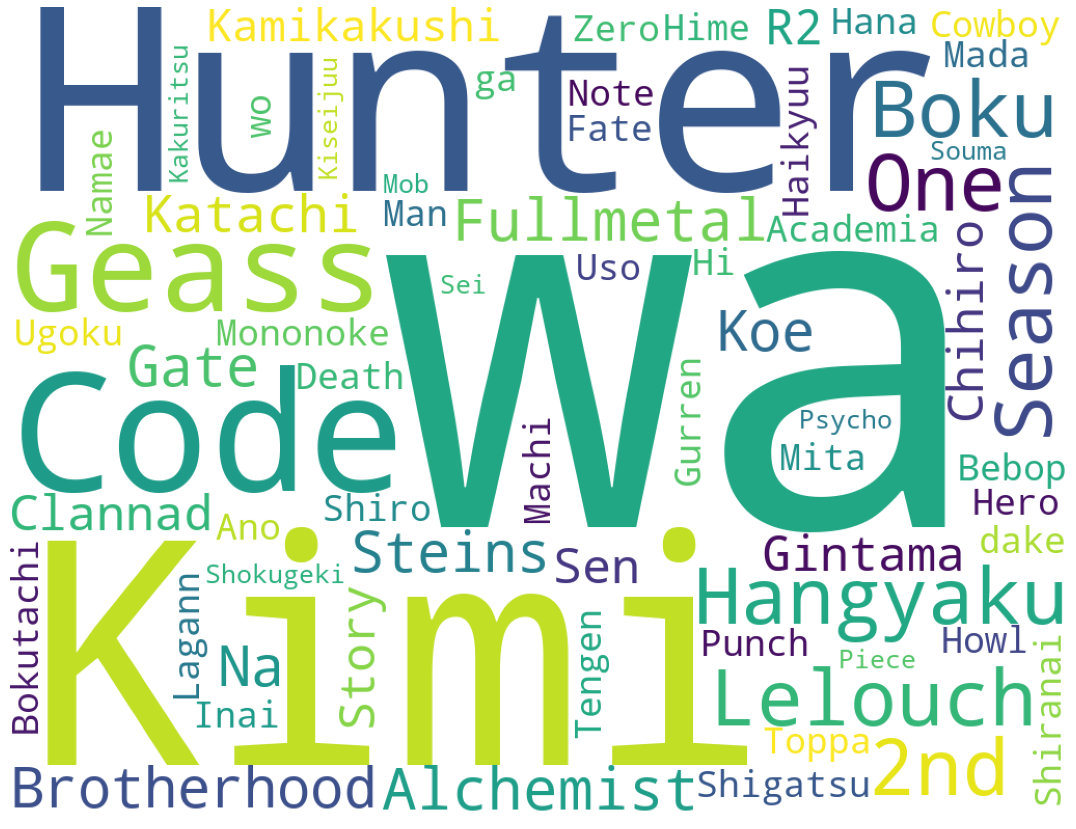

In [ ]:
#lets see the most popular titles in the dataset
plt.subplots(figsize=(30,15))
wordcloud = WordCloud(    collocations=False,
                          background_color='white',
                          width=1024,
                          height=786
                         ).generate(" ".join(popularity_and_rank_100["title"]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

![](https://drive.google.com/file/d/1IqueivL3ugf7K0nVKZ1jTXXDhzStidM5/view?usp=sharing)

In [ ]:
# Popularity is the rank of "scored_by" (amount of scores regardless of the actual score) in an ascending order
# lets see which animes have scored the most.

anime_sorted_by_pop = df_anime[df_anime.popularity!=0].loc[:,['title','popularity','rank','scored_by']]
anime_sorted_by_pop = anime_sorted_by_pop.sort_values(by=['popularity'],ascending=True).reset_index(drop=True)
anime_sorted_by_pop.head(30)


,title,popularity,rank,scored_by
0,Death Note,1,51.0,1009477
1,Shingeki no Kyojin,2,110.0,940211
2,Sword Art Online,3,1259.0,915986
3,Fullmetal Alchemist: Brotherhood,4,1.0,733592
4,One Punch Man,5,44.0,691845
5,Tokyo Ghoul,6,560.0,659308
6,Angel Beats!,7,227.0,641851
7,Steins;Gate,8,5.0,563857
8,Code Geass: Hangyaku no Lelouch,9,30.0,627740
9,Naruto,10,745.0,648605


In [ ]:
# lets see which animes ranked higest
anime_sorted_by_rank = df_anime[df_anime.popularity!=0].loc[:,['title','rank','score','popularity']]
anime_sorted_by_rank = anime_sorted_by_rank.sort_values(by=['rank'],ascending=True).reset_index(drop=True)
anime_sorted_by_rank.head(30)

,title,rank,score,popularity
0,Fullmetal Alchemist: Brotherhood,1.0,9.25,4
1,Kimi no Na wa.,2.0,9.19,33
2,Gintama°,3.0,9.15,383
3,Steins;Gate 0,4.0,9.15,323
4,Steins;Gate,5.0,9.14,8
5,Ginga Eiyuu Densetsu,6.0,9.11,671
6,Gintama&#039;,7.0,9.11,342
7,Hunter x Hunter (2011),8.0,9.11,35
8,3-gatsu no Lion 2nd Season,9.0,9.10,990
9,Gintama&#039;: Enchousen,10.0,9.07,685


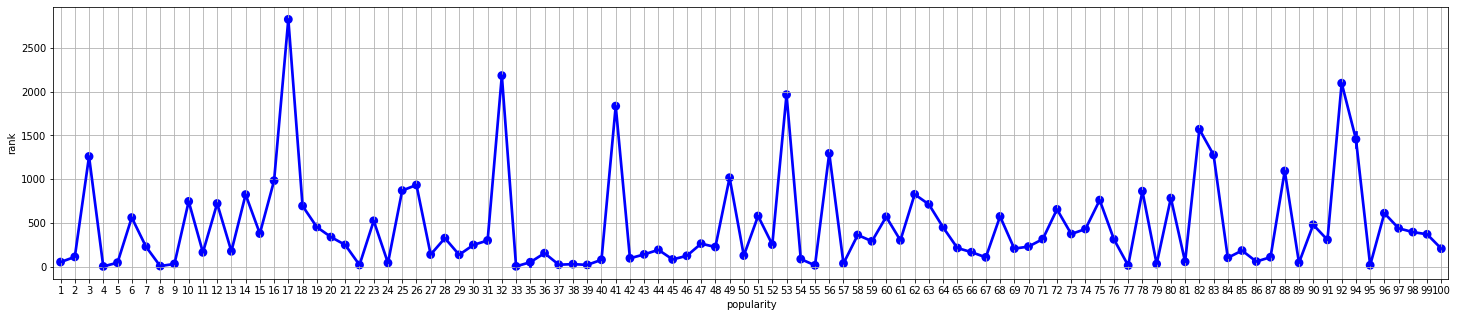

In [ ]:
#What is the most popular yet lowest ranked anime?
f,ax1 = plt.subplots(figsize =(25,5))
sns.pointplot(x='popularity',y='rank',data=anime_sorted_by_pop.head(100),color='blue')
plt.grid()


In the chart one point is striking.<br> 
17th popular anime despite a high popularity score has the worst rank score among 100 others. <br> 
This anime is Sword Art Online II. <br> 

In [ ]:
anime_sorted_by_pop[anime_sorted_by_pop["popularity"]==17]

,title,popularity,rank,scored_by
16,Sword Art Online II,17,2827.0,531486


In the first genre chart, i considered all multi-label tags.<br>
This chart is free from anime count because despite the fact that a number of anime has one genre tag, others have multiple (4,5,6) genres.

In [ ]:
anime_genre = df_anime['genre'].dropna(how=all)

genre_list = []
genre_splited = []

for i in anime_genre.index:
    for j in anime_genre[i].split(", "):
        genre_splited.append(j)
        if j not in genre_list:
            genre_list.append(j)  

unique_genres = list(dict.fromkeys(genre_splited))
unique_genres

['Comedy',
 'Supernatural',
 'Romance',
 'Shounen',
 'Parody',
 'School',
 'Magic',
 'Shoujo',
 'Drama',
 'Fantasy',
 'Kids',
 'Action',
 'Music',
 'Slice of Life',
 'Josei',
 'Harem',
 'Shounen Ai',
 'Adventure',
 'Super Power',
 'Sci-Fi',
 'Ecchi',
 'Seinen',
 'Martial Arts',
 'Game',
 'Sports',
 'Demons',
 'Historical',
 'Horror',
 'Mystery',
 'Psychological',
 'Vampire',
 'Mecha',
 'Military',
 'Space',
 'Samurai',
 'Thriller',
 'Hentai',
 'Yaoi',
 'Shoujo Ai',
 'Police',
 'Cars',
 'Dementia',
 'Yuri']

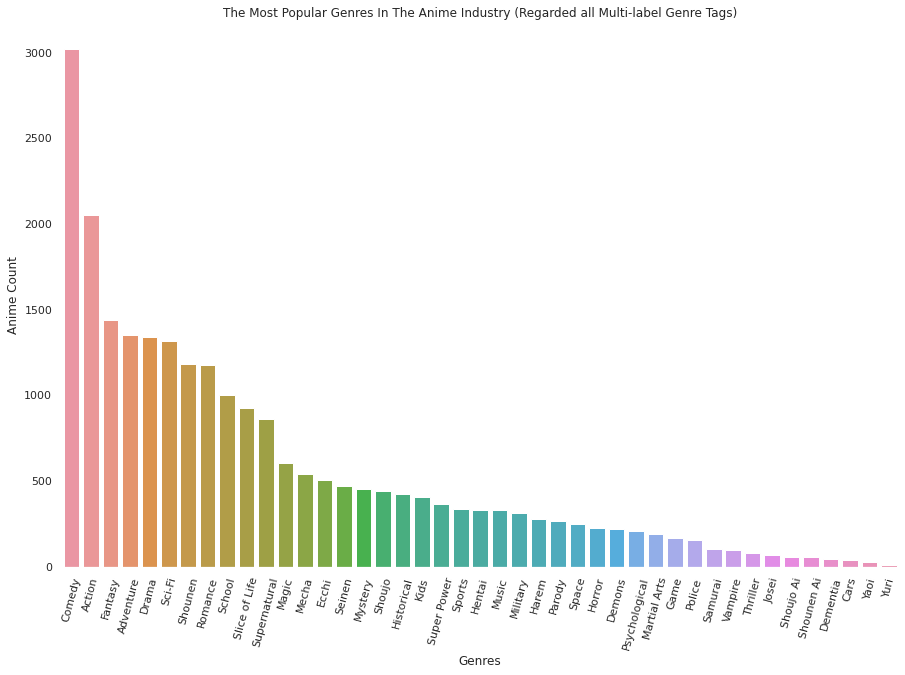

In [ ]:
#Lets see the genres distribution by all their apperances:
unique_genres = pd.Series(genre_splited).value_counts() 
plt.figure(figsize=(15,10))
sns.barplot(x=unique_genres.index.tolist(), y=unique_genres.tolist())
plt.xlabel('Genres')
plt.ylabel('Anime Count')
plt.title('The Most Popular Genres In The Anime Industry (Regarded all Multi-label Genre Tags)') 
plt.xticks(rotation= 75) 
plt.show()

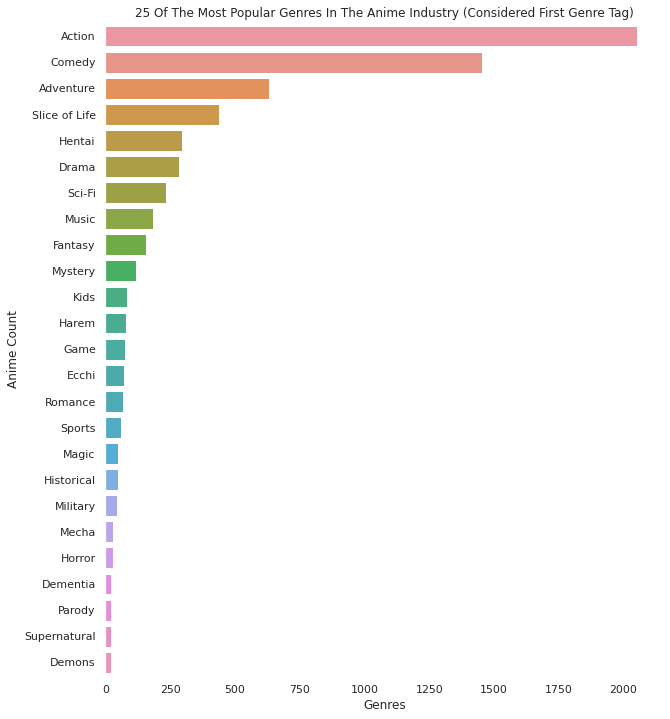

In [ ]:
# Now lets look at genres by the first value in each vector:
genre_firsts = []

for i in anime_genre.index:
    genre_firsts.append(anime_genre[i].split(", ")[0])


anime_genres_firsts = pd.Series(genre_firsts).value_counts()   

plt.figure(figsize=(10,12))
sns.barplot(x=anime_genres_firsts[0:25].tolist(), y=anime_genres_firsts[0:25].index.tolist())
plt.xlabel('Genres')
plt.ylabel('Anime Count')
plt.title('25 Of The Most Popular Genres In The Anime Industry (Considered First Genre Tag)') 
plt.rcParams['axes.facecolor'] = 'White'
plt.show()

Now lets examine our users

In [ ]:
location = [x.split(",")[1].strip() if len(x.split(",")) > 1 else x.split(",")[0].strip() 
            for x in df_anime_c["location"].astype("str")]

location[1:10]

['SPAIN',
 'PERAK',
 'ITALY',
 'RUSSIA',
 'RUSSIA',
 'VENEZUELA',
 'BRAZIL',
 'BURGAS',
 'LATVIA']

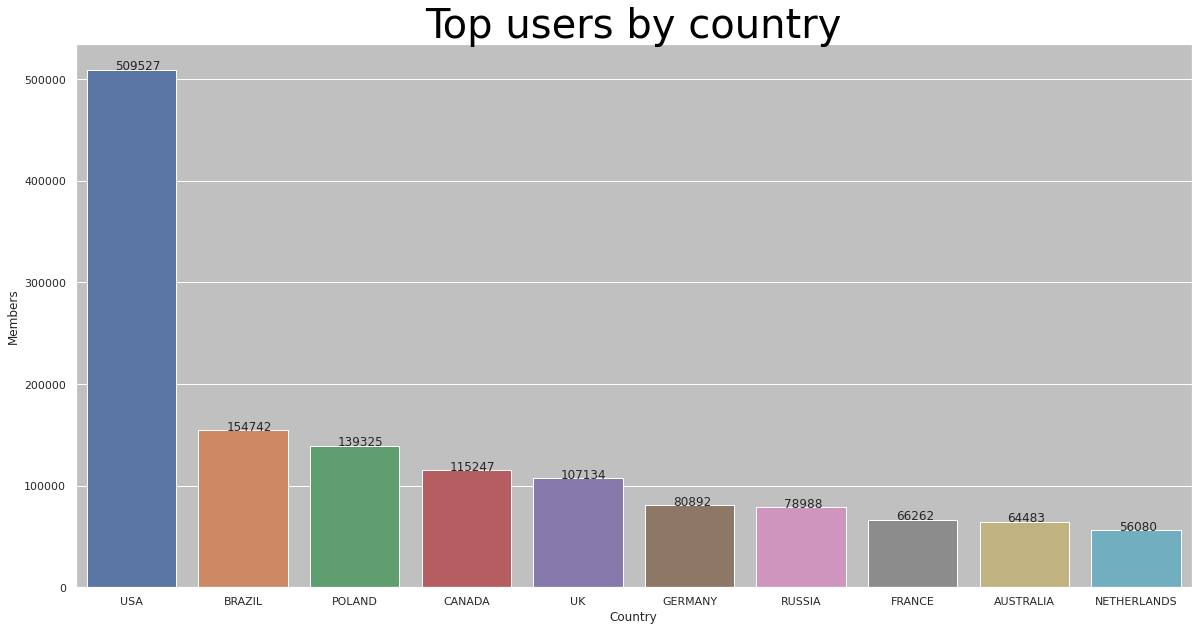

In [ ]:
#Top ten anime users by country
plt.figure(figsize=(20,10))
plt.title('Top users by country',color = 'black',fontsize=40)
location_srs = pd.Series(location).value_counts()
location_dic = pd.DataFrame({'Country':location_srs.index, 'Members':location_srs.values})
 
ax = sns.barplot(x='Country',y='Members', data=location_dic.head(10));
sns.set(rc={'figure.figsize':(20,10)})
for p, label in zip(ax.patches, location_dic["Members"]):
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+40))
plt.rcParams['axes.facecolor'] = 'White'
ax.set_facecolor('silver')
plt.show()

In [ ]:
counts = np.ones(len(df_anime_c.iloc[:,0]))
counts = pd.DataFrame(counts, columns = ['counts'])

In [ ]:
# for genre
sex_genres_df = pd.DataFrame({'genre_1':df_anime_c['genre_1'],
                              'gender':df_anime_c['gender'],
                              'counts': counts['counts']}).dropna()

sex_genres_df = pd.DataFrame(sex_genres_df.groupby(['genre_1', 'gender']).count().unstack(level=-1).dropna())
sex_genres_df = pd.DataFrame((sex_genres_df.index.to_list(),sex_genres_df.iloc[:,0].to_list(),sex_genres_df.iloc[:,1].to_list(),sex_genres_df.iloc[:,2].to_list())).transpose().rename(columns={0:'Genre',1:'Female',2:'Male',3:'Non-binary'})
#pd.DataFrame(df_anime_c[['genre_1','gender']],counts)
#grouped = df.groupby('gender')
#print(grouped['genre'].agg([np.sum]))

In [ ]:
sex_genres_df.head()

,Genre,Female,Male,Non-binary
0,Action,320264,952831,6918
1,Adventure,69810,143236,1268
2,Cars,123,769,2
3,Comedy,171123,415870,3529
4,Dementia,2668,5153,83


In [ ]:
#what are the proportions of Geners?
print(df_anime_c['gender'].value_counts(),"\n")
print(round(df_anime_c['gender'].value_counts('normalize')*100,1))

Male          2232404
Female         868855
Non-Binary      18768
Name: gender, dtype: int64 

Male          71.6
Female        27.8
Non-Binary     0.6
Name: gender, dtype: float64


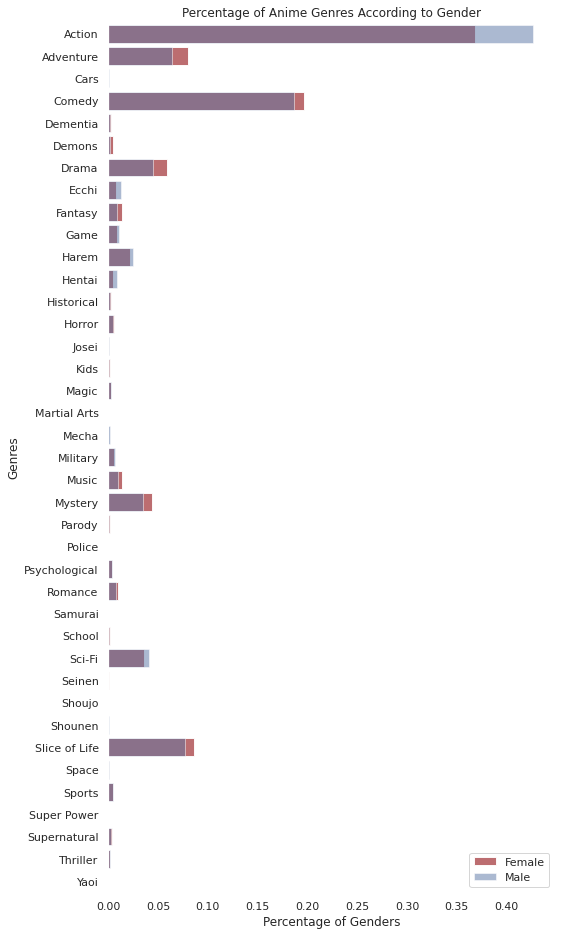

In [ ]:
#genre by male/female
Female = []
Male = []
genre_df = []
sex_genres = sex_genres_df.reset_index().iloc[:,1]

for i in sex_genres_df.index:
  genre_df.append(sex_genres_df.iloc[i,0]) 

for j in [sex_genres_df.index]:
  Female.append((sex_genres_df.iloc[j,1])/(sum(sex_genres_df.iloc[j,1])))
  Male.append((sex_genres_df.iloc[j,2])/(sum(sex_genres_df.iloc[j,2])))

f,ax = plt.subplots(figsize=(8,16))
sns.barplot(x=pd.DataFrame(Female).iloc[0,:], y=pd.DataFrame(sex_genres).iloc[:,0], label='Female', color='r', alpha = 0.9)
sns.barplot(x=pd.DataFrame(Male).iloc[0,:], y=pd.DataFrame(sex_genres).iloc[:,0], label='Male', color='b', alpha = 0.5)

ax.set(xlabel='Percentage of Genders', ylabel='Genres', title='Percentage of Anime Genres According to Gender')
ax.legend(loc='lower right',frameon= True)
plt.show()

In [ ]:
#ages?
df_user['birth_date'] = pd.to_datetime(df_user['birth_date'], errors = 'coerce')
df_user=df_user[df_user.birth_date.notnull()]

birth_date = df_user.birth_date
gender = df_user.gender
spent = df_user.user_days_spent_watching
 
age = []
for each in birth_date:
    age.append(round((datetime.now()-each).days/365.25,1))

In [ ]:
from datetime import datetime

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

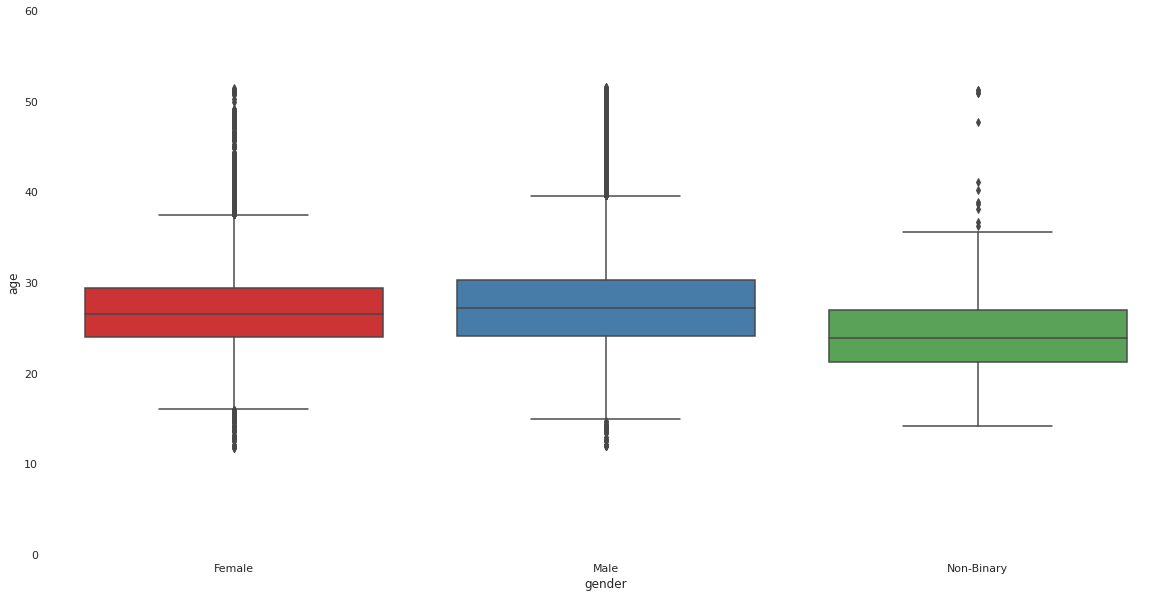

In [ ]:
#age boxplot
age_dict = {'gender':gender,'age':age,'spent':spent}
users_age_spent = pd.DataFrame(age_dict,columns=['gender','age','spent'])

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20, 10))
sns.boxplot(x="gender", y="age", data=users_age_spent, palette="Set1", ax=ax)
ax.set_ylim([0, 60])
plt.show()

In [ ]:
users_age_spent['gender'].value_counts()

Male          70880
Female        37330
Non-Binary      501
Name: gender, dtype: int64

In [ ]:
age.sort()
age[0:5]

#in the first step i dropped obvious outliers

users_age_spent.drop(users_age_spent[users_age_spent.spent>1000].index, inplace=True)
users_age_spent.drop(users_age_spent[users_age_spent.age>80].index, inplace=True)

In [ ]:
users_age_spent.head()

,gender,age,spent
0,Female,30.3,55.091667
1,Male,29.0,82.574306
2,Male,29.7,159.483333
3,Female,22.0,11.394444
4,Male,20.8,30.458333


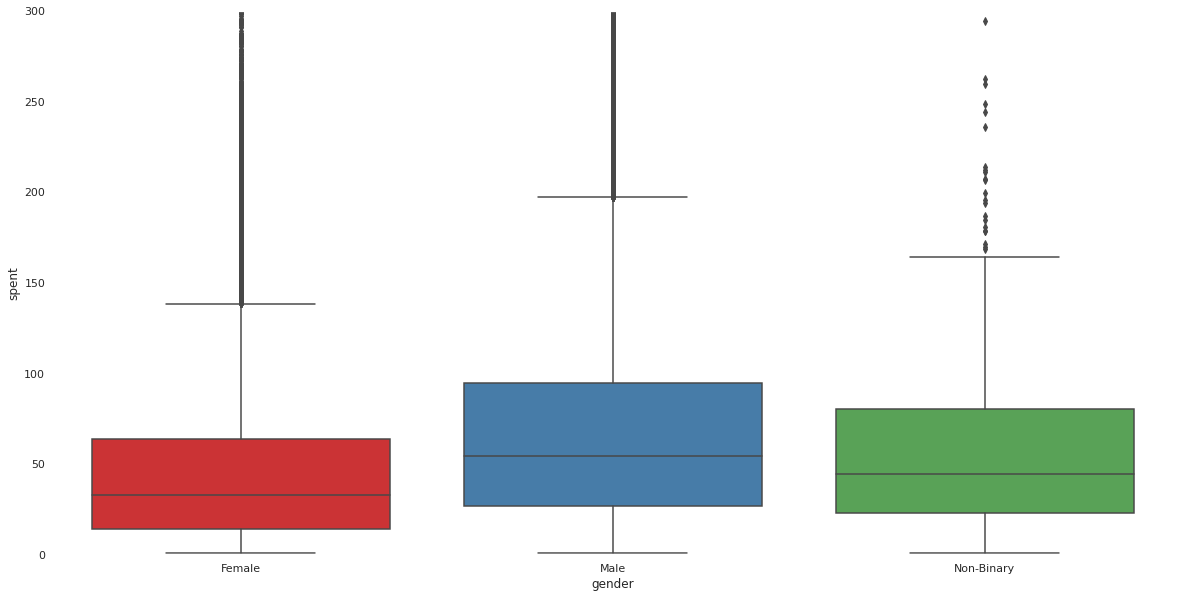

In [ ]:
#Time spent watching
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20, 10))
sns.boxplot(x="gender", y="spent", data=users_age_spent, palette="Set1", ax=ax)
ax.set_ylim([0, 300])
plt.show()

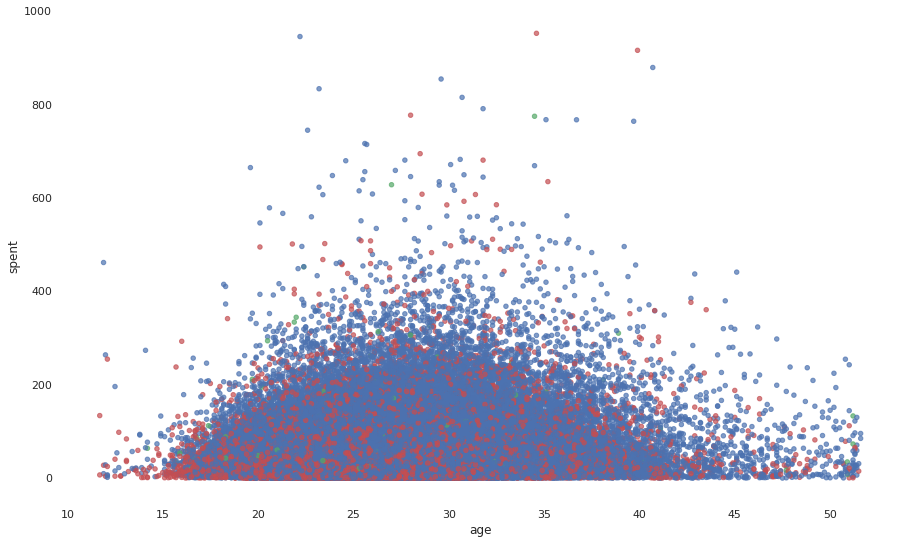

In [ ]:
users_age_spent.plot(kind='scatter', x='age', y='spent', alpha=0.7, figsize = (15,9),
                     color=["r" if each =="Female" else "g" if each == "Non-Binary" else "b" for each in users_age_spent.gender])
plt.show()

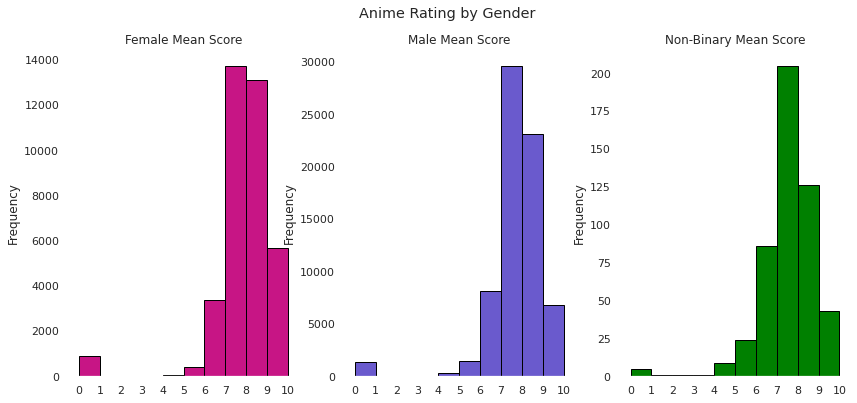

In [ ]:
F_stats = df_user[(df_user["gender"]=='Female') & (df_user["stats_episodes"]>=0)].loc[:,["stats_rewatched","stats_mean_score"]]     
M_stats = df_user[(df_user["gender"]=='Male') & (df_user["stats_episodes"]>=0)].loc[:,["stats_rewatched","stats_mean_score"]]    
B_stats = df_user[(df_user["gender"]=='Non-Binary') & (df_user["stats_episodes"]>=0)].loc[:,["stats_rewatched","stats_mean_score"]] 

f,ax=plt.subplots(1,3,figsize=(14,6))
F_stats.stats_mean_score.plot.hist(ax=ax[0],bins=10,edgecolor='black',color='mediumvioletred')
ax[0].set_title('Female Mean Score')
x1=list(range(0,11,1))
ax[0].set_xticks(x1)
M_stats.stats_mean_score.plot.hist(ax=ax[1],bins=10,edgecolor='black',color='slateblue')
ax[1].set_title('Male Mean Score')
x2=list(range(0,11,1))
ax[1].set_xticks(x2)
B_stats.stats_mean_score.plot.hist(ax=ax[2],bins=10,edgecolor='black',color='green')
ax[2].set_title('Non-Binary Mean Score')
x3=list(range(0,11,1))
ax[2].set_xticks(x3)
plt.suptitle('Anime Rating by Gender')
plt.show()

Animes Distribution by different values:

In [ ]:
#anime types
animetypes = df_anime['type'].value_counts(dropna=False)
print(animetypes)

TV         2980
OVA        1345
Special     928
Movie       907
ONA         406
Music        98
Name: type, dtype: int64


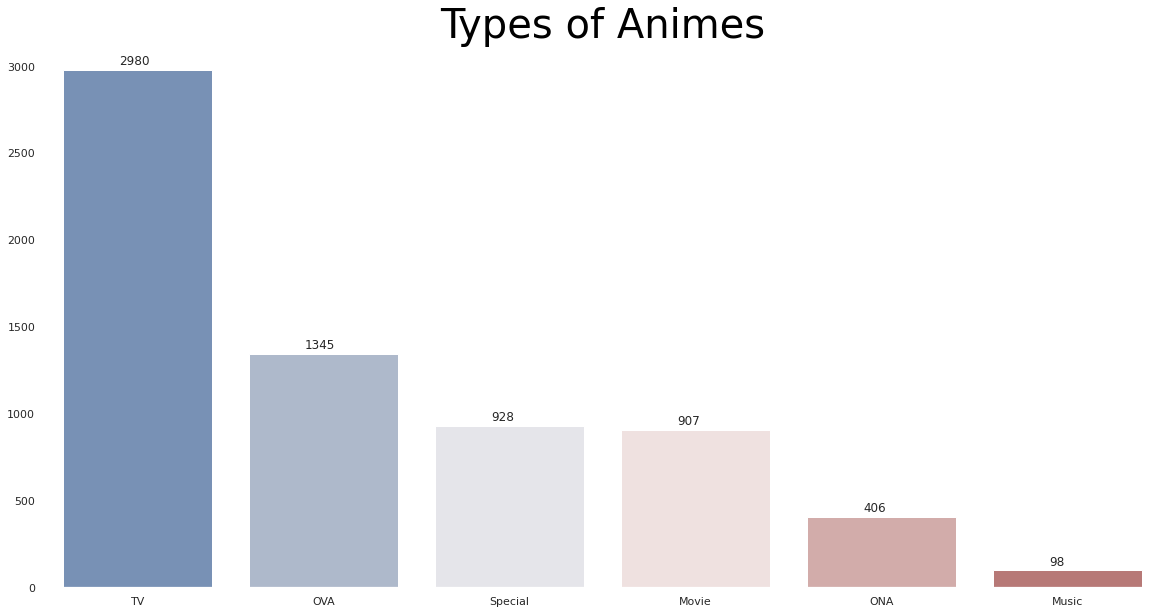

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x=animetypes.index,y=animetypes.values, palette="vlag")
plt.title('Types of Animes',color = 'black',fontsize=40)
sns.set(rc={'figure.figsize':(20,10)})
for p, label in zip(ax.patches, animetypes):
    ax.annotate(label, (p.get_x()+0.3, p.get_height()+30))
plt.show()

In [ ]:
#distribution by anime source:

animesources= df_anime['source'].value_counts(dropna=False)
animesources = animesources[animesources.index != 'Unknown']
animesources


Manga            2492
Original         1787
Light novel       511
Visual novel      482
Game              424
Novel             282
4-koma manga      194
Other             170
Web manga         111
Music              55
Picture book       53
Card game          46
Book               45
Digital manga       7
Radio               5
Name: source, dtype: int64

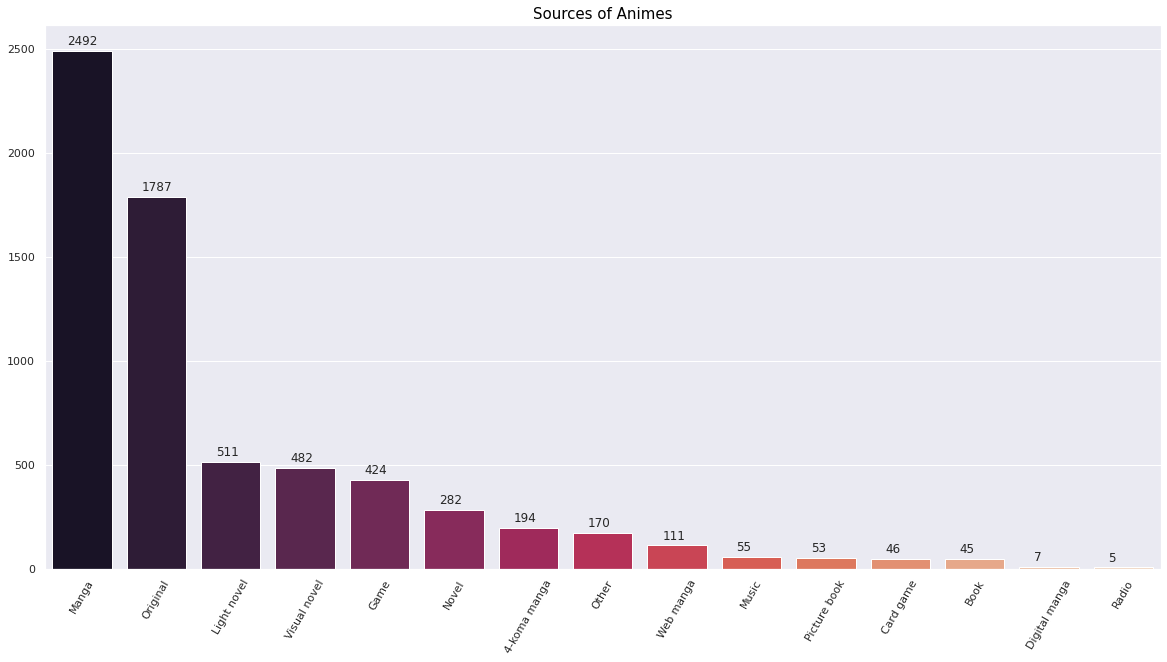

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x=animesources.index,y=animesources.values, palette="rocket")
plt.xticks(rotation=60)
plt.title('Sources of Animes',color = 'black',fontsize=15)
sns.set(rc={'figure.figsize':(20,10)})
for p, label in zip(ax.patches, animesources):
    ax.annotate(label, (p.get_x()+0.2, p.get_height()+30))
plt.show()

In [ ]:
df_anime.dropna(subset=['rating'],axis=0,inplace=True)

In [ ]:
df_anime['rating'].value_counts()

PG-13 - Teens 13 or older         3396
G - All Ages                      1043
R - 17+ (violence & profanity)     758
R+ - Mild Nudity                   566
PG - Children                      487
Rx - Hentai                        332
None                                82
Name: rating, dtype: int64

Let's do some Statistics!<br>
![Let's do some Statistics!](https://memeguy.com/photos/images/-statistics-13128.jpg)



In [ ]:
df_anime.describe()

,anime_id,episodes,score,scored_by,rank,popularity,members,favorites,duration_min,aired_from_year
count,6664.000000,6664.000000,6664.000000,6.664000e+03,6308.000000,6664.000000,6.664000e+03,6664.000000,6664.000000,6664.000000
mean,15055.875900,14.284364,6.849802,2.404887e+04,4324.648542,4476.655612,4.751758e+04,670.767257,28.458886,2006.910264
std,13158.833713,40.917913,0.926975,6.113674e+04,3168.954788,3451.339341,1.051468e+05,3824.185052,25.364405,10.382424
min,1.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000,1.800000e+01,0.000000,0.000000,1942.000000
25%,2588.250000,1.000000,6.350000,6.835000e+02,1710.000000,1691.000000,2.232750e+03,3.000000,17.000000,2003.000000
50%,10393.500000,6.000000,6.930000,3.977000e+03,3752.500000,3627.500000,1.035150e+04,21.000000,24.000000,2010.000000
75%,30292.250000,13.000000,7.460000,1.977125e+04,6334.000000,6624.500000,4.336650e+04,142.250000,27.000000,2015.000000
max,37896.000000,1818.000000,9.520000,1.009477e+06,12856.000000,14468.000000,1.456378e+06,106895.000000,163.000000,2018.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f60fcd39b70>,
      dtype=object)

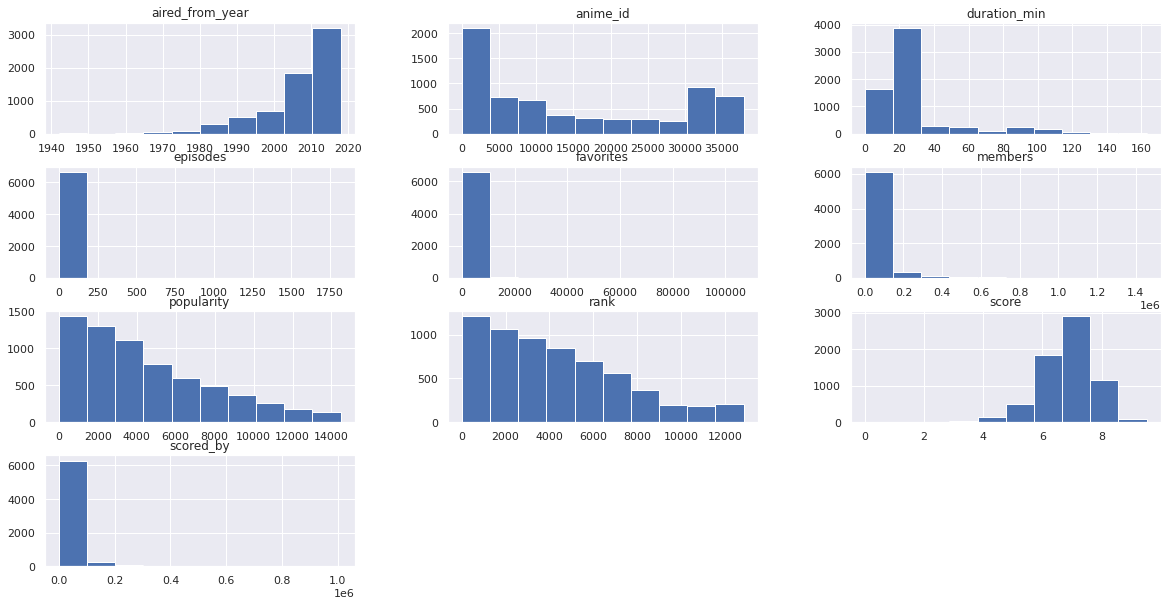

In [ ]:
df_anime_col = df_anime.select_dtypes(exclude=['string','bool'])
df_anime_col.hist()

In [ ]:
df_user.describe()

,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,access_rank,stats_mean_score,stats_rewatched,stats_episodes
count,1.087110e+05,108711.000000,108711.000000,108711.000000,108711.000000,108711.000000,108711.000000,0.0,108711.000000,108711.000000,108711.000000
mean,1.817687e+06,14.767503,196.458178,11.388167,11.733716,75.578589,61.913873,NaN,7.747612,14.197993,3779.871255
std,1.998269e+06,32.746591,244.945751,30.830825,30.978991,178.653664,59.211762,NaN,1.451368,55.376799,3678.336729
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.500694,NaN,0.000000,0.000000,7.000000
25%,1.994345e+05,3.000000,50.000000,0.000000,0.000000,6.000000,21.066319,NaN,7.330000,0.000000,1269.500000
50%,5.675030e+05,7.000000,123.000000,4.000000,3.000000,27.000000,46.190278,NaN,7.890000,1.000000,2797.000000
75%,3.477036e+06,16.000000,254.000000,12.000000,12.000000,81.000000,84.461806,NaN,8.460000,10.000000,5135.000000
max,7.251737e+06,2934.000000,5479.000000,2562.000000,2457.000000,12051.000000,952.654595,NaN,10.000000,9404.000000,62347.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6025047710>,
      dtype=object)

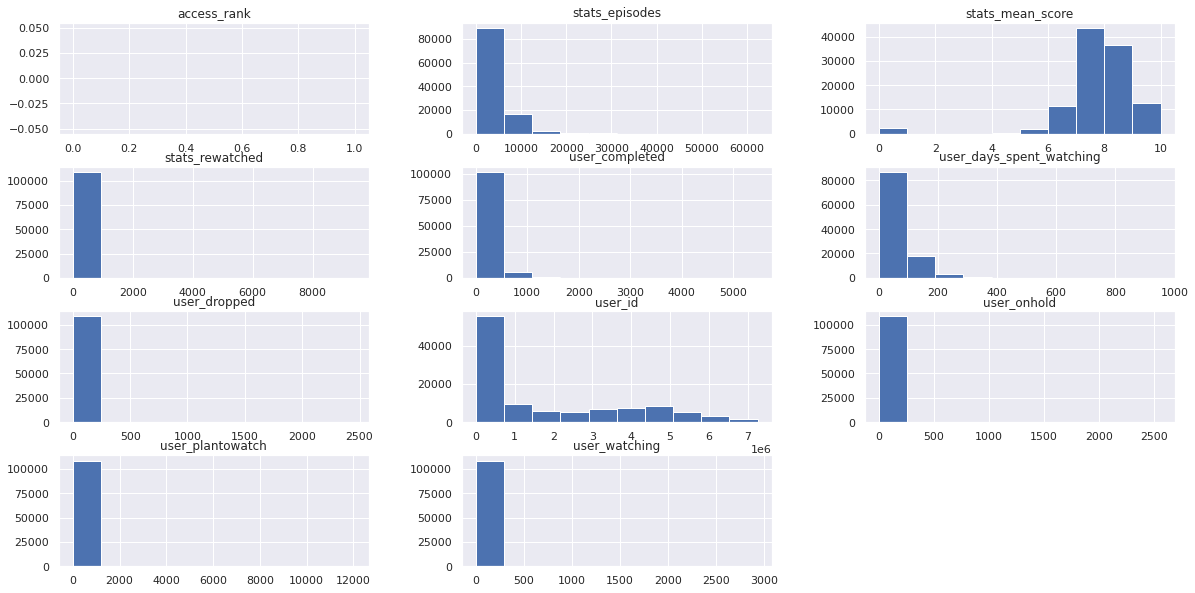

In [ ]:
df_user_col = df_user.select_dtypes(exclude=['string','bool'])
df_user_col.hist()

In [ ]:
df_anime_c.describe()

,user_id,anime_id,popularity,my_watched_episodes,my_score,my_status,my_rewatching,my_rewatching_ep,age
count,3.120027e+06,3.120027e+06,3.120027e+06,3.120027e+06,3.120027e+06,3.120027e+06,2.433344e+06,3.120027e+06,3.120027e+06
mean,1.890142e+06,1.169080e+04,1.134464e+03,1.289339e+01,4.656650e+00,3.006895e+00,8.132841e-04,2.541645e-03,2.696902e+01
std,1.970990e+06,1.134252e+04,1.307020e+03,3.686702e+01,3.931919e+00,1.729985e+00,2.850654e-02,4.163268e-01,4.722448e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.100000e+01
25%,2.178090e+05,1.601000e+03,2.270000e+02,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01
50%,1.087343e+06,8.074000e+03,6.890000e+02,4.000000e+00,6.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,2.700000e+01
75%,3.596371e+06,1.977500e+04,1.564000e+03,1.300000e+01,8.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01
max,7.251737e+06,3.788800e+04,1.442900e+04,7.500000e+03,1.000000e+01,5.500000e+01,1.000000e+00,2.910000e+02,5.100000e+01


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6025959908>,
      dtype=object)

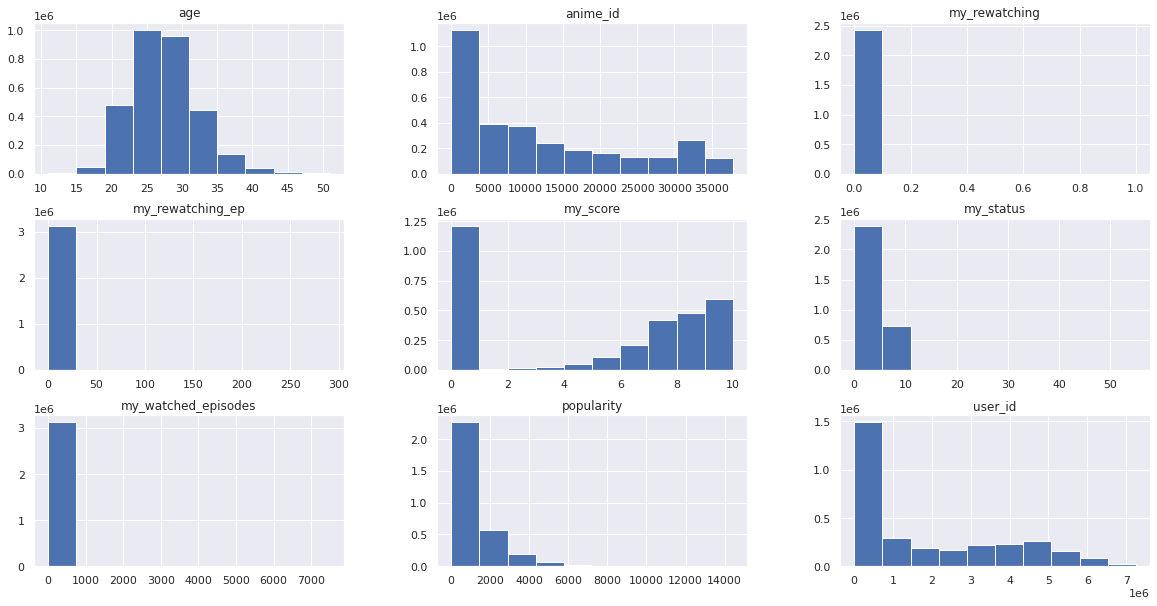

In [ ]:
df_anime_c_col = df_anime_c.select_dtypes(exclude=['string','bool'])
df_anime_c_col.hist()

In [ ]:
ScoresDF = df_anime_c[['username', 'anime_id', 'my_score', 'my_status','location','age','genre_1','genre']]
ScoresDF['my_score'].describe().apply(lambda x: format(x, '.2f')).reset_index()

lower_rating = ScoresDF['my_score'].min()
upper_rating = ScoresDF['my_score'].max()
print('Range of ratings vary between: {0} to {1}'.format(lower_rating, upper_rating))
UsersAndScores = ScoresDF['username'].value_counts().reset_index().rename(columns={"username": "animes_rated", "index": "username"})

Range of ratings vary between: 0 to 10


In [ ]:
UsersAndScores = pd.merge(UsersAndScores, df_user, left_on = 'username', right_on = 'username', how = 'inner')

In [ ]:
UserRatedsAggregated = UsersAndScores['animes_rated'].value_counts().reset_index().rename(columns={"animes_rated": "group_size", "index": "animes_rated"}).sort_values(by=['animes_rated'])

In [ ]:
RatedsPerAnime = ScoresDF['anime_id'].value_counts().reset_index().rename(columns={"anime_id": "number_of_users", "index": "anime_id"})
RatedsPerAnime.head()

,anime_id,number_of_users
0,1535,8178
1,1575,6793
2,4224,6479
3,226,6428
4,6547,6275


In [ ]:
AnimeRatedsAggregated = RatedsPerAnime['number_of_users'].value_counts().reset_index().rename(columns={"number_of_users": "group_size", "index": "number_of_users"}).sort_values(by=['number_of_users'])
AnimeRatedsAggregated.head()

,number_of_users,group_size
0,1,128
1,2,122
2,3,94
3,4,73
4,5,72


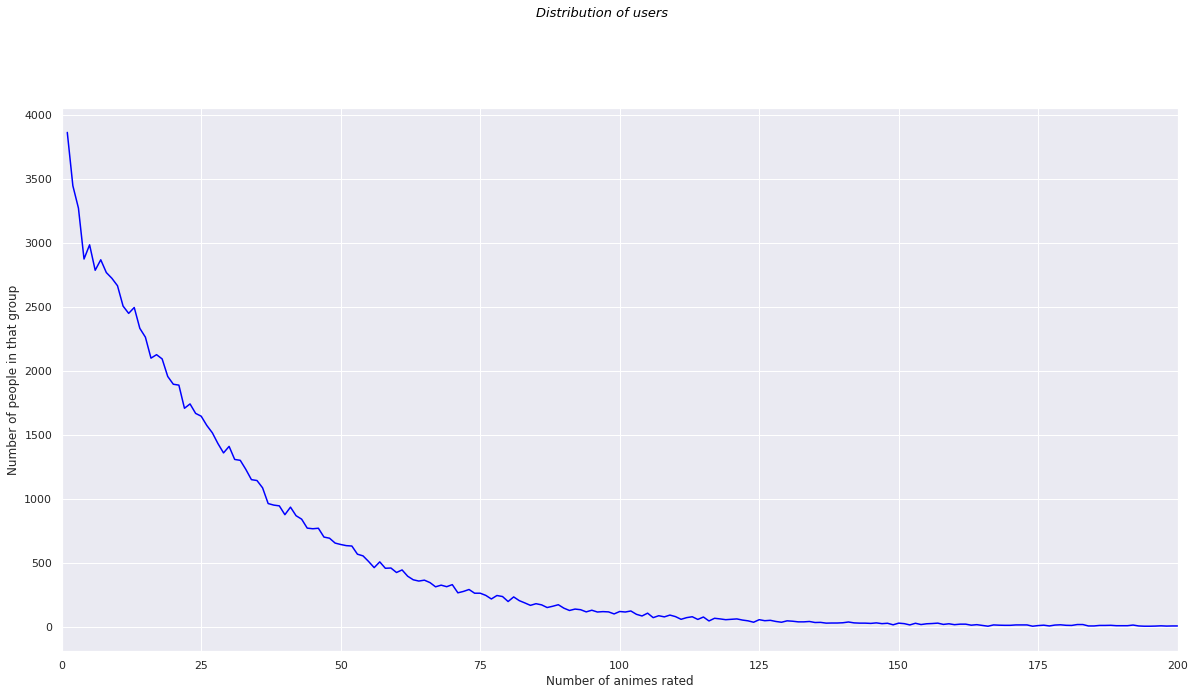

In [ ]:
#Creating the plots so we can gather information about the distribution of ratings in the sample
plt.suptitle("Distribution of users", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.plot('animes_rated', 'group_size', data = UserRatedsAggregated, color = 'blue')
plt.xlabel('Number of animes rated')
plt.ylabel('Number of people in that group')
plt.xlim(left = 0, right = 200)
plt.show()

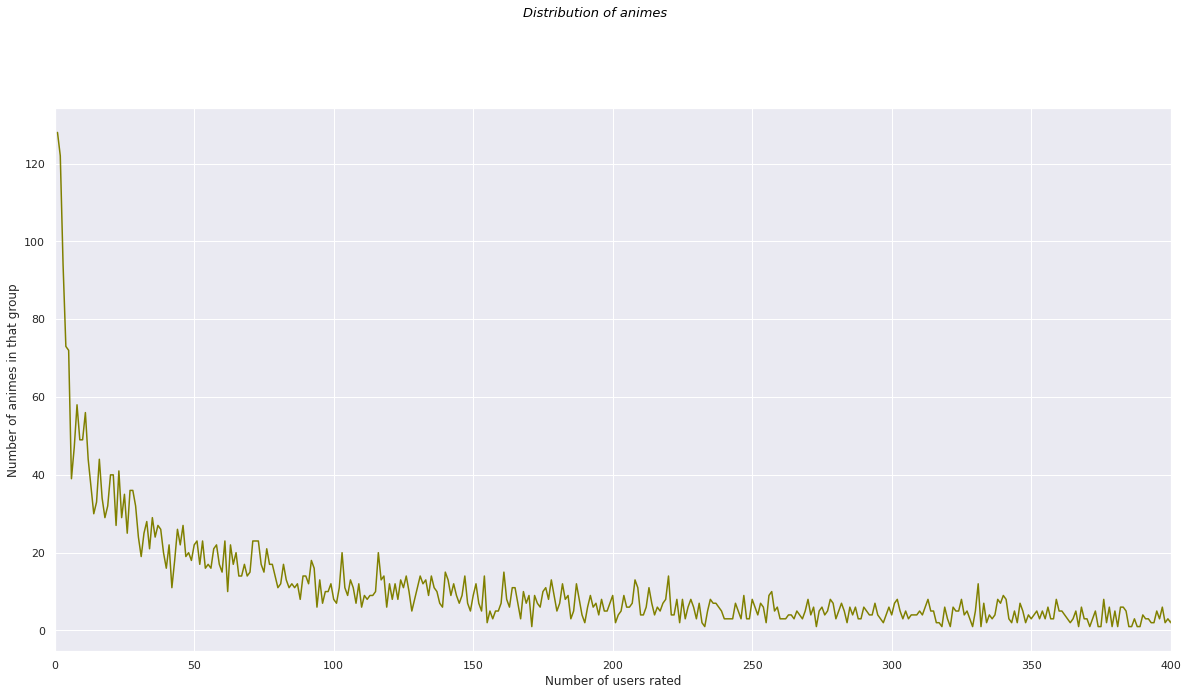

In [ ]:
#Creating the plots so we can gather information about the distribution of ratings in the sample
plt.suptitle("Distribution of animes", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.plot('number_of_users', 'group_size', data = AnimeRatedsAggregated, color = 'olive')
plt.xlabel('Number of users rated')
plt.ylabel('Number of animes in that group')
plt.xlim(left = 0, right = 400)
plt.show()


In [ ]:
UserLocation = ScoresDF['location'].value_counts().reset_index().rename(columns={"location": "group_size", "index": "location"}).sort_values(by=['group_size'], ascending=False)
UserLocation.head()


,location,group_size
0,USA,509527
1,BRAZIL,154742
2,POLAND,139325
3,CANADA,115247
4,UK,107134


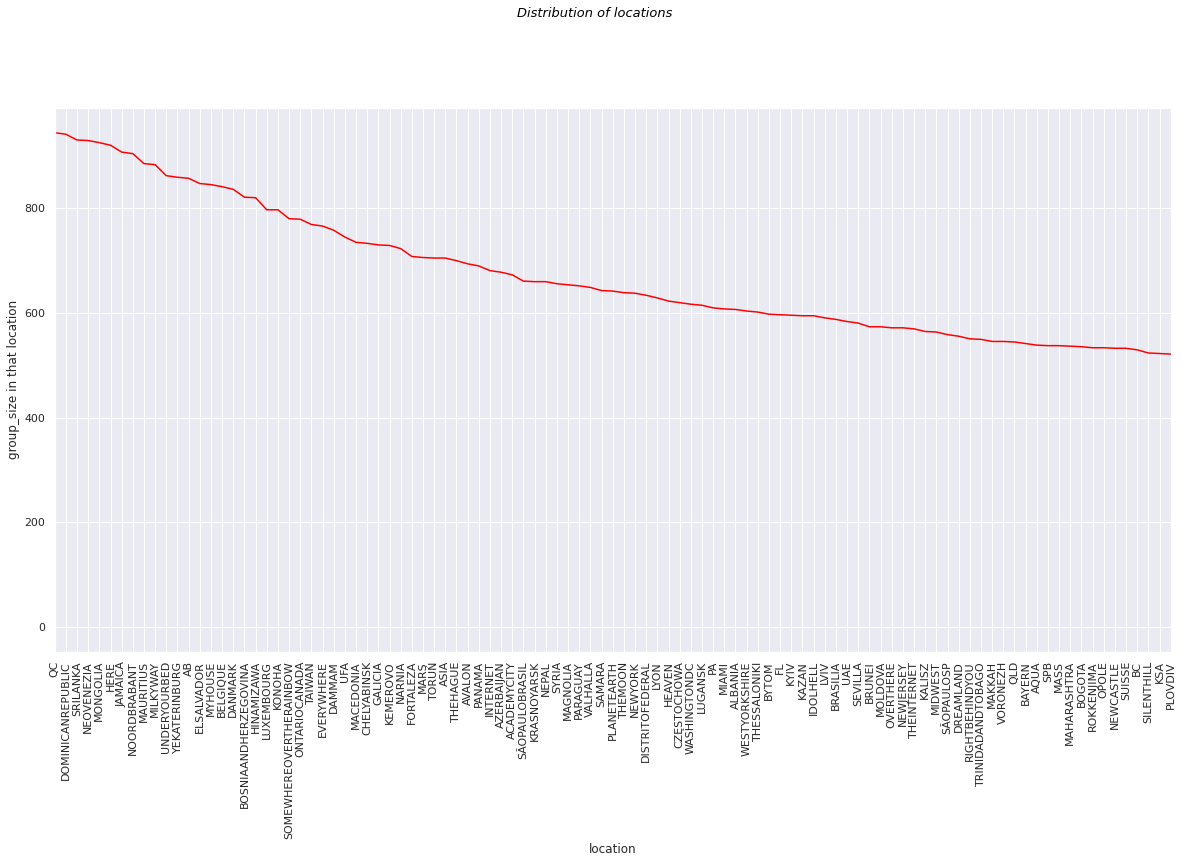

In [ ]:
#We also need to filter location noise
plt.suptitle("Distribution of locations", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.plot('location', 'group_size', data = UserLocation.iloc[100:10000000,:], color = 'red')
plt.xlabel('location')
plt.xticks(rotation=90)
plt.ylabel('group_size in that location')
plt.xlim(left = 0, right = 100)
plt.show()

In [ ]:
#Creating a dataframe of users  and animes with more than 10 interactions
UserRatedsCutten = UsersAndScores[UsersAndScores['animes_rated'] >= 10]
AnimeRatedsCutten = RatedsPerAnime[RatedsPerAnime['number_of_users'] >= 10]
LocationRatedsCutten = UserLocation[UserLocation['group_size'] >= 600]
#Joining (merging) our new dataframes with the interactions one (this will already deal with the sample problem,
#as it is an inner join). The "HotStart" name comes from a pun about solving the "Cold Start" issue
df_anime_final = pd.merge(ScoresDF, UserRatedsCutten, left_on = 'username', right_on = 'username', how = 'inner')
df_anime_final = pd.merge(df_anime_final, AnimeRatedsCutten, left_on = 'anime_id', right_on = 'anime_id', how = 'inner')
df_anime_final = pd.merge(df_anime_final, LocationRatedsCutten, left_on = 'location_x', right_on = 'location', how = 'inner')

Here we can imply being that the data has a peak at the score of number '8', <br>probably when someone really likes a show it rates them at that minimum.<br> Interesting to see too that we have a lot of rated '0', Otakus are really demanding apparently.

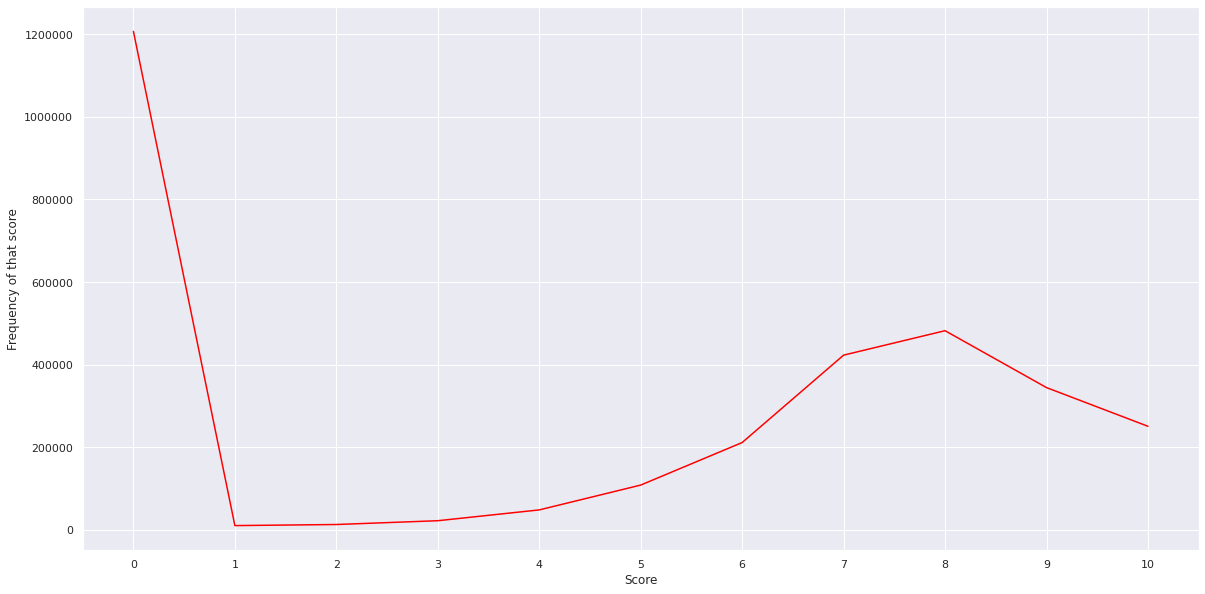

In [ ]:
#Grouping the different scores and resetting the index (so the series could become a DF again) 

AnimeRates = ScoresDF['my_score'].value_counts().reset_index().sort_values('index')
plt.plot('index', 'my_score', data = AnimeRates, color = 'red')
plt.xticks(np.arange(11))
plt.ticklabel_format(axis = 'y', style = 'plain')
plt.xlabel('Score')
plt.ylabel('Frequency of that score')
plt.show()

In [ ]:
print('The initial dataframe has {0} registers and the sampled one has {1} rows.'.format(ScoresDF['username'].count(), df_anime_final['username'].count()))

The initial dataframe has 3120008 registers and the sampled one has 2246681 rows.


In [ ]:
df_anime_final.head()

,username,anime_id,my_score,my_status,location_x,age,genre_1,genre,animes_rated,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location_y,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes,number_of_users,location,group_size
0,happily_UnDead,18679,9,2,SWEDEN,26,Action,"Action, Comedy, Super Power, Ecchi, School",22,2307201,3,145,0,2,47,52.356250,Male,sweden,1994-07-02,NaN,2013-03-15 00:00:00,2017-03-28 01:37:00,7.29,1.0,3063,4122,SWEDEN,43526
1,Daizuko,18679,6,2,SWEDEN,37,Action,"Action, Comedy, Super Power, Ecchi, School",74,562629,25,587,12,0,156,118.518576,Male,"Stockholm, Sweden",1983-03-08,NaN,2011-09-02 00:00:00,2018-05-04 17:41:13,6.87,48.0,7293,4122,SWEDEN,43526
2,Purryflurry,18679,9,2,SWEDEN,28,Action,"Action, Comedy, Super Power, Ecchi, School",24,1229959,5,214,2,12,16,114.454861,Male,Sweden,1992-04-27,NaN,2012-04-03 00:00:00,2018-05-12 15:48:18,6.43,0.0,6861,4122,SWEDEN,43526
3,Ronin_Andreas,18679,7,2,SWEDEN,31,Action,"Action, Comedy, Super Power, Ecchi, School",58,26829,31,379,39,7,72,85.590972,Male,"Malmö, Sweden",1989-07-20,NaN,2007-12-19 00:00:00,2017-10-11 10:12:00,7.99,59.0,5112,4122,SWEDEN,43526
4,Loffe,18679,8,1,SWEDEN,30,Action,"Action, Comedy, Super Power, Ecchi, School",35,279315,20,299,8,15,120,95.440972,Male,sweden,1990-06-14,NaN,2010-01-06 00:00:00,2018-01-17 00:24:46,7.66,5.0,5779,4122,SWEDEN,43526


In [ ]:
#lets drop access_rank, its all null
df_anime_final = df_anime_final.drop(['access_rank','location_y','number_of_users','group_size'],axis=1)

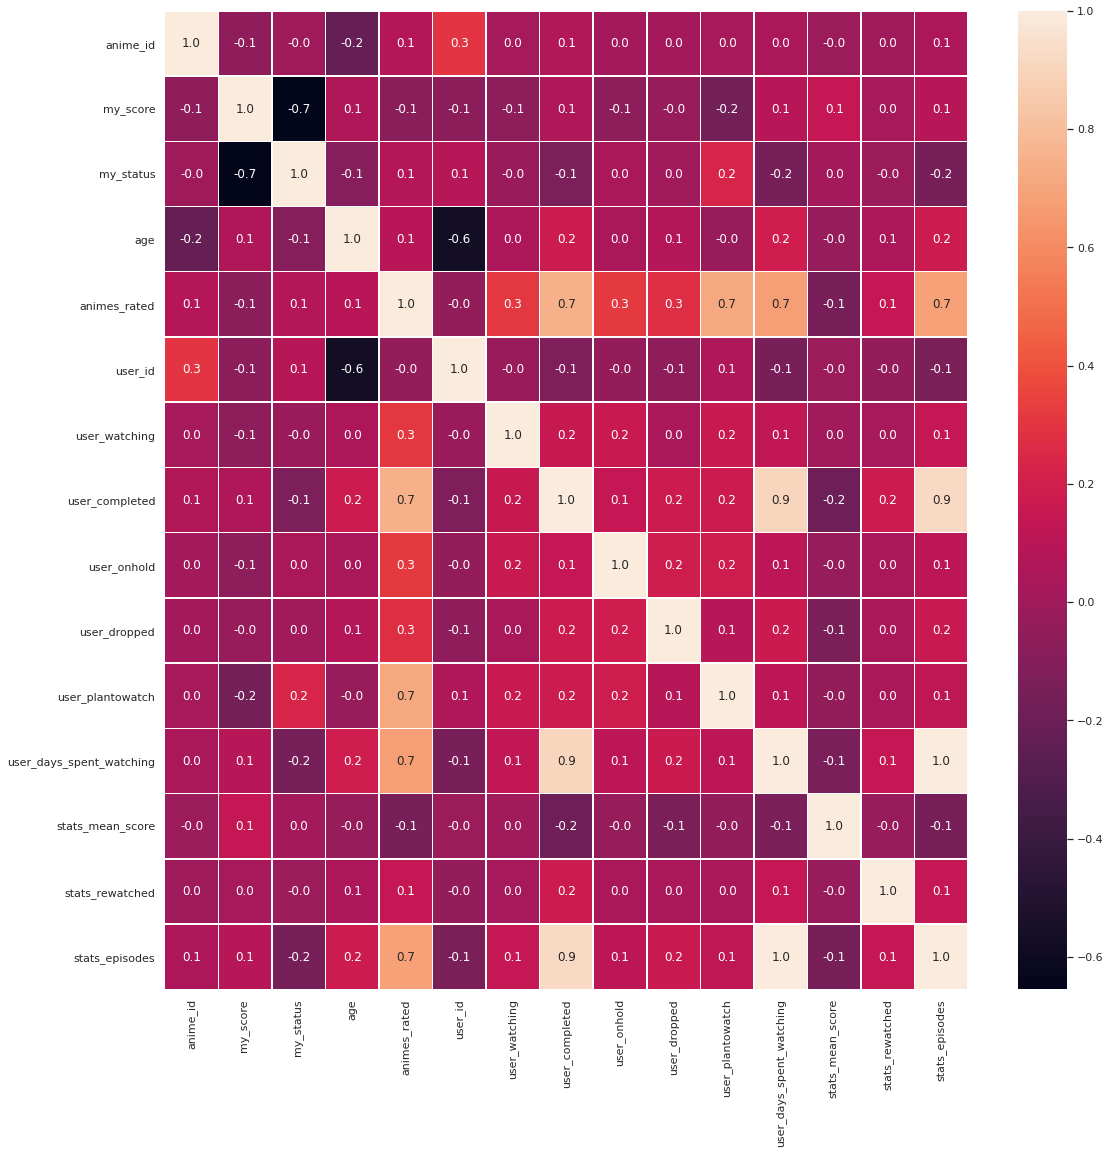

In [ ]:
#finaly, lets look at our variables
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df_anime_final.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [ ]:
df_anime_final = pd.get_dummies(df_anime_final, columns=['gender'])

In [ ]:
df_anime_final = df_anime_final.drop(['gender_Non-Binary'],axis=1)

In [ ]:
df_anime_final.head()

,username,anime_id,my_score,my_status,location_x,age,genre_1,genre,animes_rated,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,birth_date,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes,location,gender_Female,gender_Male
0,happily_UnDead,18679,9,2,SWEDEN,26,Action,"Action, Comedy, Super Power, Ecchi, School",22,2307201,3,145,0,2,47,52.356250,1994-07-02,2013-03-15 00:00:00,2017-03-28 01:37:00,7.29,1.0,3063,SWEDEN,0,1
1,Daizuko,18679,6,2,SWEDEN,37,Action,"Action, Comedy, Super Power, Ecchi, School",74,562629,25,587,12,0,156,118.518576,1983-03-08,2011-09-02 00:00:00,2018-05-04 17:41:13,6.87,48.0,7293,SWEDEN,0,1
2,Purryflurry,18679,9,2,SWEDEN,28,Action,"Action, Comedy, Super Power, Ecchi, School",24,1229959,5,214,2,12,16,114.454861,1992-04-27,2012-04-03 00:00:00,2018-05-12 15:48:18,6.43,0.0,6861,SWEDEN,0,1
3,Ronin_Andreas,18679,7,2,SWEDEN,31,Action,"Action, Comedy, Super Power, Ecchi, School",58,26829,31,379,39,7,72,85.590972,1989-07-20,2007-12-19 00:00:00,2017-10-11 10:12:00,7.99,59.0,5112,SWEDEN,0,1
4,Loffe,18679,8,1,SWEDEN,30,Action,"Action, Comedy, Super Power, Ecchi, School",35,279315,20,299,8,15,120,95.440972,1990-06-14,2010-01-06 00:00:00,2018-01-17 00:24:46,7.66,5.0,5779,SWEDEN,0,1


In [ ]:
#x = pd.get_dummies(x, columns=['genre_1'])

In [ ]:
columns = df_anime_final['genre_1'].unique()
matrix = np.zeros([len(df_anime),len(columns)])
Genres = pd.DataFrame(data=matrix,columns=columns)
Genres.shape

(6664, 39)

In [ ]:
df_anime['genre'] = df_anime['genre'].str.split(",")

In [ ]:
for j in range(len(df_anime['genre'])):
  for i in range(int(len(columns))):
    for k in range(int(len(df_anime['genre'][j]))):
      if ((df_anime['genre'][j][k].strip()) == (Genres.columns[i].strip())):
         Genres.iloc[j,i] = 1

In [ ]:
Genres.head()

,Action,Military,Thriller,Adventure,Harem,Comedy,Slice of Life,Demons,Mystery,Fantasy,Sci-Fi,Ecchi,Drama,Historical,Psychological,Horror,Space,Supernatural,Cars,Music,Parody,Hentai,Sports,Magic,Game,Mecha,Romance,School,Seinen,Dementia,Super Power,Shounen,Josei,Kids,Shoujo,Samurai,Police,Yaoi,Martial Arts
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_anime_1 = pd.concat([df_anime,Genres],axis=1)

In [ ]:
df_anime_1.head()

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year,Action,Military,Thriller,Adventure,Harem,Comedy,Slice of Life,Demons,Mystery,Fantasy,Sci-Fi,Ecchi,Drama,Historical,Psychological,Horror,Space,Supernatural,Cars,Music,Parody,Hentai,Sports,Magic,Game,Mecha,Romance,School,Seinen,Dementia,Super Power,Shounen,Josei,Kids,Shoujo,Samurai,Police,Yaoi,Martial Arts
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,False,"Jan 13, 2012 to Mar 30, 2012","{'from': '2012-01-13', 'to': '2012-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,7.63,139250,1274.0,231,283882,2809,Inu x Boku SS was licensed by Sentai Filmworks...,Winter 2012,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"[Comedy, Supernatural, Romance, Shounen]","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,False,"Apr 2, 2007 to Oct 1, 2007","{'from': '2007-04-02', 'to': '2007-10-01'}",24 min. per ep.,PG-13 - Teens 13 or older,7.89,91206,727.0,366,204003,2579,NaN,Spring 2007,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"[Comedy, Parody, Romance, School, Shounen]","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,False,"Oct 4, 2008 to Sep 25, 2009","{'from': '2008-10-04', 'to': '2009-09-25'}",24 min. per ep.,PG - Children,7.55,37129,1508.0,1173,70127,802,NaN,Fall 2008,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"[Comedy, Magic, School, Shoujo]","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,False,"Aug 16, 2002 to May 23, 2003","{'from': '2002-08-16', 'to': '2003-05-23'}",16 min. per ep.,PG-13 - Teens 13 or older,8.21,36501,307.0,916,93312,3344,Princess Tutu aired in two parts. The first pa...,Summer 2002,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"[Comedy, Drama, Magic, Romance, Fantasy]","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,False,"Oct 6, 2012 to Mar 30, 2013","{'from': '2012-10-06', 'to': '2013-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,8.67,107767,50.0,426,182765

In [ ]:
df_anime_final = pd.merge(df_anime_final, df_anime_1, left_on = 'anime_id', right_on = 'anime_id', how = 'inner')

In [ ]:
df_anime_final.head()

,username,anime_id,my_score,my_status,location_x,age,genre_1,genre_x,animes_rated,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,birth_date,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes,location,gender_Female,gender_Male,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,...,aired_from_year,Action,Military,Thriller,Adventure,Harem,Comedy,Slice of Life,Demons,Mystery,Fantasy,Sci-Fi,Ecchi,Drama,Historical,Psychological,Horror,Space,Supernatural,Cars,Music,Parody,Hentai,Sports,Magic,Game,Mecha,Romance,School,Seinen,Dementia,Super Power,Shounen,Josei,Kids,Shoujo,Samurai,Police,Yaoi,Martial Arts
0,happily_UnDead,18679,9,2,SWEDEN,26,Action,"Action, Comedy, Super Power, Ecchi, School",22,2307201,3,145,0,2,47,52.356250,1994-07-02,2013-03-15 00:00:00,2017-03-28 01:37:00,7.29,1.0,3063,SWEDEN,0,1,Kill la Kill,KILL la KILL,キルラキル,"KLK, Dressed to Kill",https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,24,Finished Airing,False,"Oct 4, 2013 to Mar 28, 2014","{'from': '2013-10-04', 'to': '2014-03-28'}",24 min. per ep.,PG-13 - Teens 13 or older,8.19,...,2013.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Daizuko,18679,6,2,SWEDEN,37,Action,"Action, Comedy, Super Power, Ecchi, School",74,562629,25,587,12,0,156,118.518576,1983-03-08,2011-09-02 00:00:00,2018-05-04 17:41:13,6.87,48.0,7293,SWEDEN,0,1,Kill la Kill,KILL la KILL,キルラキル,"KLK, Dressed to Kill",https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,24,Finished Airing,False,"Oct 4, 2013 to Mar 28, 2014","{'from': '2013-10-04', 'to': '2014-03-28'}",24 min. per ep.,PG-13 - Teens 13 or older,8.19,...,2013.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Purryflurry,18679,9,2,SWEDEN,28,Action,"Action, Comedy, Super Power, Ecchi, School",24,1229959,5,214,2,12,16,114.454861,1992-04-27,2012-04-03 00:00:00,2018-05-12 15:48:18,6.43,0.0,6861,SWEDEN,0,1,Kill la Kill,KILL la KILL,キルラキル,"KLK, Dressed to Kill",https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,24,Finished Airing,False,"Oct 4, 2013 to Mar 28, 2014","{'from': '2013-10-04', 'to': '2014-03-28'}",24 min. per ep.,PG-13 - Teens 13 or older,8.19,...,2013.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ronin_Andreas,18679,7,2,SWEDEN,31,Action,"Action, Comedy, Super Power, Ecchi, School",58,26829,31,379,39,7,72,85.590972,1989-07-20,2007-12-19 00:00:00,2017-10-11 10:12:00,7.99,59.0,5112,SWEDEN,0,1,Kill la Kill,KILL la KILL,キルラキル,"KLK, Dressed to Kill",https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,24,Finished Airing,False,"Oct 4, 2013 to Mar 28, 2014","{'from': '2013-10-04', 'to': '2014-03-28'}",24 min. per ep.,PG-13 - Teens 13 or older,8.19,...,2013.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Loffe,18679,8,1,SWEDEN,30,Action,"Action, Comedy, Super Power, Ecchi, School",35,279315,20,299,8,15,120,95.440972,1990-06-14,2010-01-06 00:00:00,2018-01-17 00:24:46,7.66,5.0,5779,SWEDEN,0,1,Kill la Kill,KILL la KILL,キルラキル,"KLK, Dressed to Kill",https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,24,Finished Airing,False,"Oct 4, 2013 to Mar 28, 2014","{'from': '2013-10-04', 'to': '2014-03-28'}",24 min. per ep.,PG-13 - Teens 13 or older,8.19,...,2013.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#df_anime_final.to_csv('/content/drive/My Drive/Colab Notebooks/datasets_anime/df_anime_final.csv', index = False)

In [ ]:
#path = "/content/drive/My Drive/Colab Notebooks/datasets_anime/df_anime_final.csv"
#df_anime_final = pd.read_csv(path)

Next Notebook - Modeling!
![](https://i.kinja-img.com/gawker-media/image/upload/t_original/b1mxqsaff5uqj8hp7dvd.png)